# Indoor Scene Recognition using PyTorch

## Importing the Libraries

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data_dir  = r"C:\Users\karwa\Jupyter\Indoor Navigation\Images"

In [3]:
classes = os.listdir(data_dir)
print(classes)

['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']


In [4]:
len(classes)

67

## Transformations

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


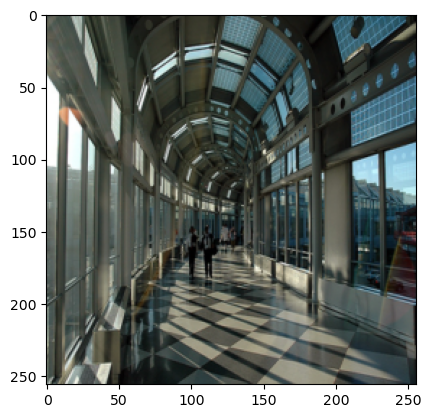

In [7]:
img, label = dataset[50]
show_sample(img, label)

## Data Splitting

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
len(dataset)

15620

In [10]:
train_ds, val_ds, test_ds = random_split(dataset, [13000, 2000, 620])
len(train_ds), len(val_ds), len(test_ds)

(13000, 2000, 620)

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

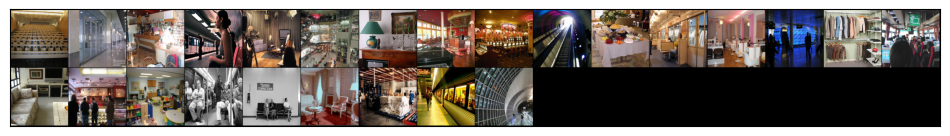

In [14]:
show_batch(train_dl)

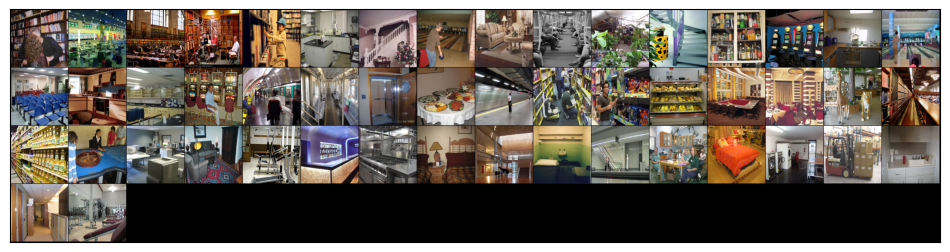

In [15]:
show_batch(val_dl)

## Building the first Neural Network Model

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

## Using Resnet 50 for model training

In [17]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

C:\Users\karwa\.conda\envs\DeepLearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\karwa\.conda\envs\DeepLearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

## Training the Model

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(ResNet(), device)

In [23]:
evaluate(model, val_dl)

{'val_loss': 4.211418628692627, 'val_acc': 0.01599999889731407}

In [24]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 6e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 3.6520, val_loss: 3.4422, val_acc: 0.6395
Epoch 2: train_loss: 3.3981, val_loss: 3.3851, val_acc: 0.6990
Epoch 3: train_loss: 3.3276, val_loss: 3.3638, val_acc: 0.7245
Epoch 4: train_loss: 3.2964, val_loss: 3.3641, val_acc: 0.7420
Epoch 5: train_loss: 3.2797, val_loss: 3.3611, val_acc: 0.7435
Epoch 6: train_loss: 3.2718, val_loss: 3.3545, val_acc: 0.7605
Epoch 7: train_loss: 3.2674, val_loss: 3.3665, val_acc: 0.7480
Epoch 8: train_loss: 3.2612, val_loss: 3.3714, val_acc: 0.7440
Epoch 9: train_loss: 3.2583, val_loss: 3.3661, val_acc: 0.7605
Epoch 10: train_loss: 3.2552, val_loss: 3.3647, val_acc: 0.7625
Epoch 11: train_loss: 3.2544, val_loss: 3.3702, val_acc: 0.7530
Epoch 12: train_loss: 3.2517, val_loss: 3.3724, val_acc: 0.7630
Epoch 13: train_loss: 3.2500, val_loss: 3.3754, val_acc: 0.7410
Epoch 14: train_loss: 3.2493, val_loss: 3.3704, val_acc: 0.7630
Epoch 15: train_loss: 3.2483, val_loss: 3.3810, val_acc: 0.7520
Epoch 16: train_loss: 3.2481, val_loss: 3.3767, v

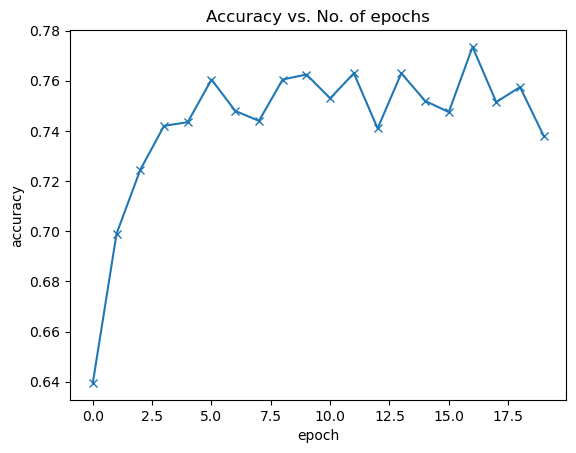

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

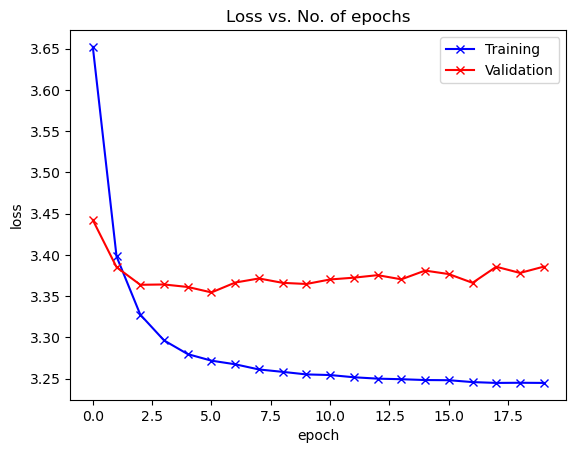

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [28]:
evaluate(model, val_dl)

{'val_loss': 3.3857476711273193, 'val_acc': 0.7380000352859497}

## Visualising predictions on Test Set

In [29]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: livingroom , Predicted: livingroom


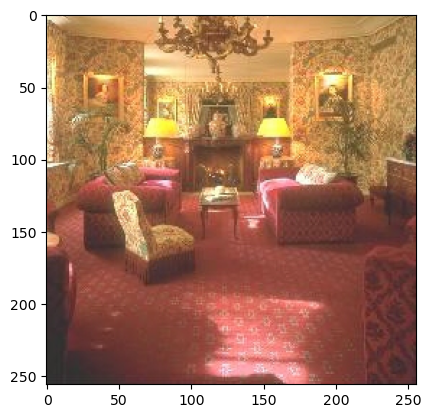

In [31]:
img, label = test_ds[110]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: deli , Predicted: deli


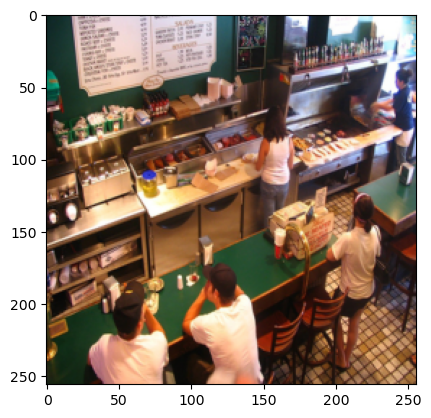

In [32]:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Predicting External Images

In [33]:
import urllib.request

In [36]:
urllib.request.urlretrieve("https://images.squarespace-cdn.com/content/v1/5a7497e29f8dcee376b70f7e/1591630503059-FBBWAYXPWYOK9BTIBMZY/ke17ZwdGBToddI8pDm48kA_SSaoz4elkj-HsZd8gX3Z7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UWPwZyNcweDIvdeL5kotwkIXjs9g0WibSO_cU-Ijy4Pwg6poS-6WGGnXqDacZer4yQ/74586587_10157705983079085_1307946016988725248_o+%281%29.jpg?format=2500w", "bar.jpg")
    
urllib.request.urlretrieve("https://sika.scene7.com/is/image/sika/glo-elevator-appliances?wid=1280&crop=0%2C80%2C4615%2C3212", "elevator.jpg") 
urllib.request.urlretrieve("https://i.pinimg.com/originals/2b/15/9d/2b159da035e4e3aaa30c03ec8ba7816c.jpg", "gameroom.jpg")
urllib.request.urlretrieve("https://i.pinimg.com/originals/a6/d9/d7/a6d9d743da7017a7bcf4a53e46d22f81.jpg", "inside_bus.jpg")
urllib.request.urlretrieve("https://s.wsj.net/public/resources/images/ON-CE927_moviet_B1280_20170714200426.jpg", "theatre.jpg")

('theatre.jpg', <http.client.HTTPMessage at 0x20748a19900>)

In [37]:
loaded_model = model

In [38]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles bar.


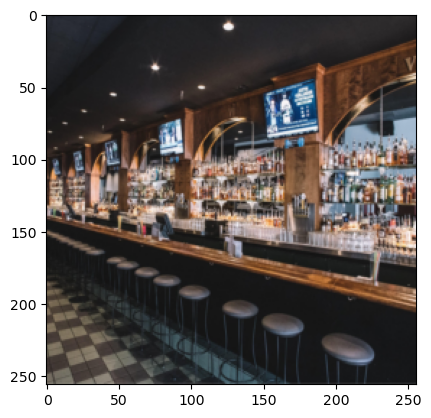

In [39]:
predict_external_image('bar.jpg')

The image resembles corridor.


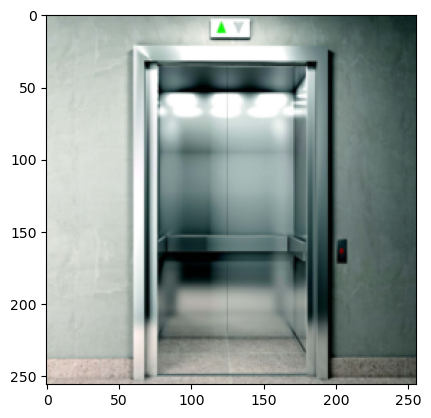

In [40]:
predict_external_image('elevator.jpg')

The image resembles bar.


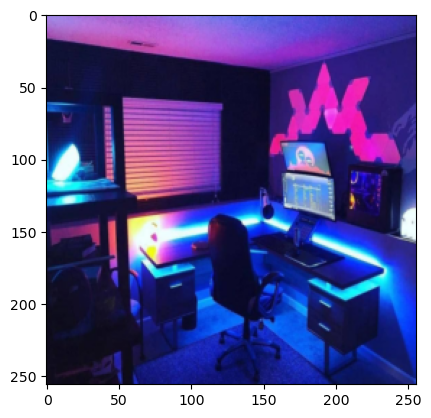

In [41]:
predict_external_image('gameroom.jpg')

The image resembles movietheater.


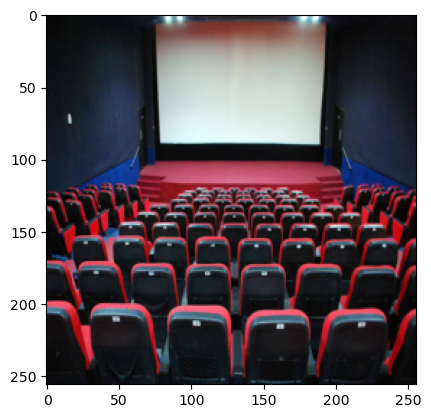

In [42]:
predict_external_image('theatre.jpg')


## Integrating gtts to get the recited Prediction

In [43]:
from gtts import gTTS
import IPython.display as ipd
import os

In [44]:
def predict_external_image_speech(image_name):
    # Load and preprocess the image
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    
    # Display the image
    plt.imshow(example_image.permute(1, 2, 0))

    # Get the prediction
    prediction = predict_image(example_image, loaded_model)
    print("The image resembles", prediction + ".")

    # Convert prediction to speech
    tts = gTTS(prediction)
    audio_path = 'prediction.mp3'
    tts.save(audio_path)

    # Return an audio player widget to play the prediction
    return ipd.Audio(audio_path)

The image resembles movietheater.


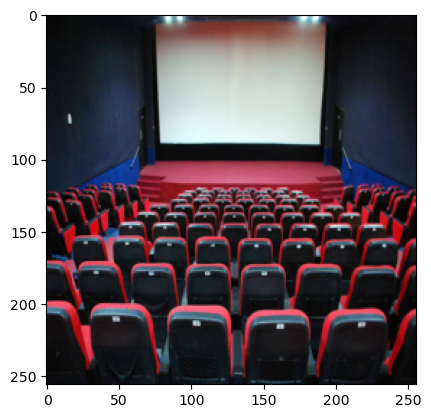

In [45]:
predict_external_image_speech('theatre.jpg')

The image resembles bar.


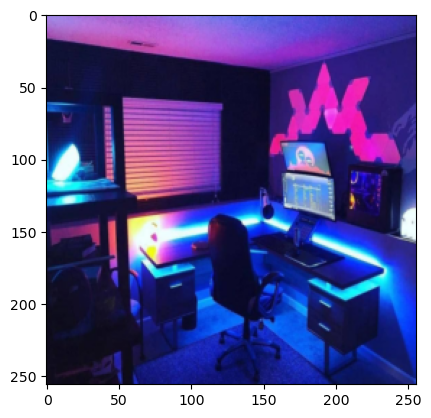

In [46]:
predict_external_image_speech('gameroom.jpg')

The image resembles bar.


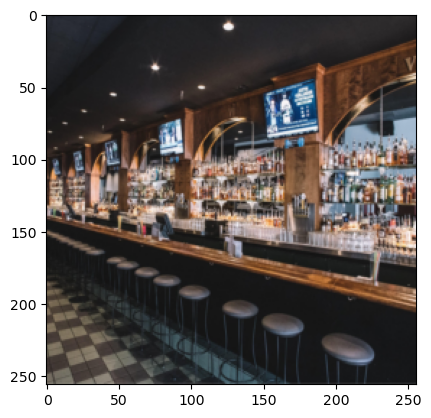

In [48]:
predict_external_image_speech('bar.jpg')

The image resembles corridor.


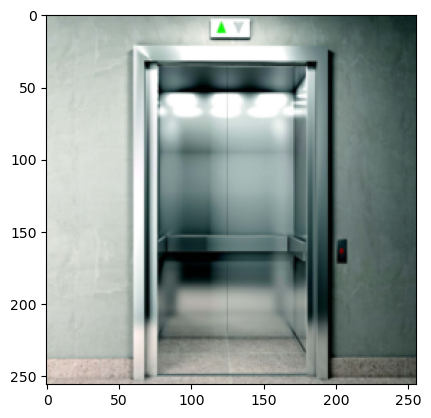

In [50]:
predict_external_image_speech('elevator.jpg')

The image resembles livingroom.


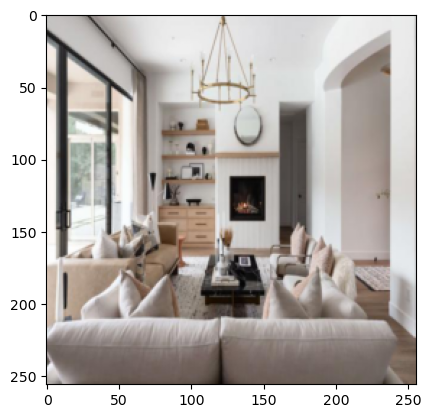

In [51]:
predict_external_image_speech('livingroom.jpeg')

The image resembles bathroom.


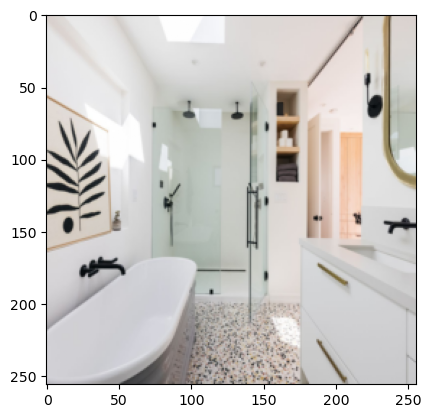

In [52]:
predict_external_image_speech('bathroom.jpg')

The image resembles kitchen.


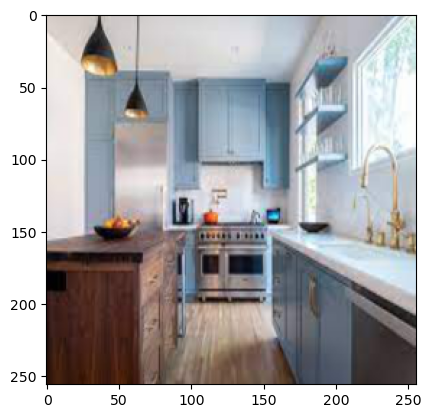

In [53]:
predict_external_image_speech('kitchen.jpeg')

The image resembles bedroom.


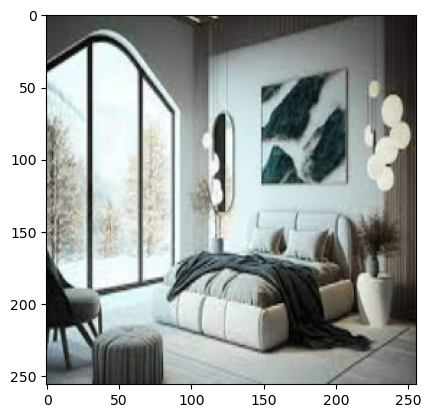

In [54]:
predict_external_image_speech('bedroom.jpeg')

## Object Detection 

In [56]:
import torch
from ultralytics import YOLO

In [58]:
#Testing YOLOv5
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

C:\Users\karwa\.conda\envs\DeepLearning\lib\site-packages\torch\hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\karwa/.cache\torch\hub\master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ------------------------------------- 190.6/190.6 kB 11.3 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 18.4 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 8.1s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5  2023-12-13 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 48.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 720x1280 2 persons, 2 ties
Speed: 624.8ms pre-process, 55.5ms inference, 29.1ms NMS per image at shape (1, 3, 384, 640)
Saved 1 image to runs\detect\exp


xmin        ymin         xmax        ymax  confidence  class    name
0  742.965942   48.338501  1141.821045  720.000000    0.881280      0  person
1  442.001984  437.513977   496.651520  709.961365    0.675300     27     tie
2  123.029449  193.228333   715.674561  719.751770    0.665496      0  person
3  982.803040  308.398529  1027.380493  419.996979    0.259727     27     tie

In [57]:
def detect_objects(image_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # Load YOLOv5 model
    results = model(image_path)
    return results.pandas().xyxy[0]  # Return detection results as a pandas DataFrame

In [59]:
from gtts import gTTS
import IPython.display as ipd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def predict_external_image_object(image_name):
    # Load and preprocess the image
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    
    # Display the image
    plt.imshow(example_image.permute(1, 2, 0))

    # Get the scene prediction
    scene_prediction = predict_image(example_image, loaded_model)

    # Get object detection results
    object_detection_results = detect_objects(image_name)
    objects = ', '.join(object_detection_results['name'].unique())  # List unique detected objects

    # Print and recite the combined prediction
    combined_prediction = f"The scene is {scene_prediction} and the objects within the scene are {objects}."
    print(combined_prediction)

    # Convert combined prediction to speech
    tts = gTTS(combined_prediction)
    audio_path = 'combined_prediction.mp3'
    tts.save(audio_path)

    # Return an audio player widget to play the combined prediction
    return ipd.Audio(audio_path)


In [60]:
predict_external_image_object('bedroom.jpeg')

Using cache found in C:\Users\karwa/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-12-13 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


The scene is bedroom and the objects within the scene are chair, vase, bed, potted plant.


In [61]:
predict_external_image_object('kitchen.jpeg')

Using cache found in C:\Users\karwa/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-12-13 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


The scene is kitchen and the objects within the scene are oven, bowl, refrigerator.


In [62]:
predict_external_image_object('bathroom.jpg')

Using cache found in C:\Users\karwa/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-12-13 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


The scene is bathroom and the objects within the scene are sink.


In [63]:
predict_external_image_object('livingroom.jpeg')

Using cache found in C:\Users\karwa/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-12-13 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


The scene is livingroom and the objects within the scene are couch, tv, chair, book.
